In [1]:
import torch
import requests
import kornia
import numpy as np
import random
import glob
import cv2
from skimage.metrics import structural_similarity as ssim
from PIL import Image
from matplotlib import pyplot as plt
from transformers import AutoImageProcessor, AutoModel
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url_image1 = "https://raw.githubusercontent.com/magicleap/SuperGluePretrainedNetwork/refs/heads/master/assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
image1 = Image.open(requests.get(url_image1, stream=True).raw)
url_image2 = "https://raw.githubusercontent.com/magicleap/SuperGluePretrainedNetwork/refs/heads/master/assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
image2 = Image.open(requests.get(url_image2, stream=True).raw)

images = [image1, image2]
print(images)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1016x762 at 0x77341E50BE50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1048x626 at 0x77341DBCD890>]


In [3]:
# image1 = Image.open('./test_images/result07.jpg')
# image2 = Image.open('./test_images/result08.jpg')

# images = [image1, image2]
# print(images)

In [4]:
processor = AutoImageProcessor.from_pretrained("ETH-CVG/lightglue_superpoint")
model = AutoModel.from_pretrained("ETH-CVG/lightglue_superpoint")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
inputs = processor(images, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

image_sizes = [[(image.height, image.width) for image in images]]
outputs = processor.post_process_keypoint_matching(outputs, image_sizes, threshold=0.2)
for i, stitched_image in enumerate(outputs):
    print("For the image pair", i)
    for keypoint0, keypoint1, matching_score in zip(
            stitched_image["keypoints0"], stitched_image["keypoints1"], stitched_image["matching_scores"]
    ):
        print(
            f"Keypoint at coordinate {keypoint0.numpy()} in the first image matches with keypoint at coordinate {keypoint1.numpy()} in the second image with a score of {matching_score}."
        )


For the image pair 0
Keypoint at coordinate [650  65] in the first image matches with keypoint at coordinate [715 215] in the second image with a score of 0.8331103920936584.
Keypoint at coordinate [638  66] in the first image matches with keypoint at coordinate [707 213] in the second image with a score of 0.6369764804840088.
Keypoint at coordinate [625  85] in the first image matches with keypoint at coordinate [694 229] in the second image with a score of 0.8461472988128662.
Keypoint at coordinate [665  85] in the first image matches with keypoint at coordinate [730 228] in the second image with a score of 0.915942907333374.
Keypoint at coordinate [644 119] in the first image matches with keypoint at coordinate [710 251] in the second image with a score of 0.9673681259155273.
Keypoint at coordinate [625 125] in the first image matches with keypoint at coordinate [697 259] in the second image with a score of 0.4251830577850342.
Keypoint at coordinate [663 127] in the first image matc

/home/mwuerstle@corp.exxcellent.de/miniconda3/envs/cv-project/lib/python3.11/site-packages/transformers/models/lightglue/image_processing_lightglue.py:485: FutureWarning: `plot_keypoint_matching` is deprecated and will be removed in transformers v. Use `visualize_keypoint_matching` instead.
  warnings.warn(


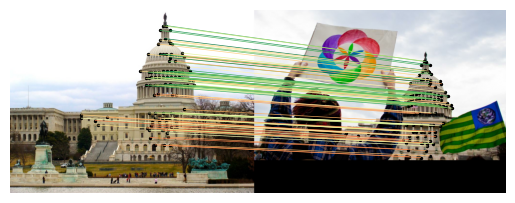

In [6]:
processor.plot_keypoint_matching(images, outputs)

In [7]:
def stitch_images(img0_pil, img1_pil, output, device='cpu'):
    to_tensor = T.ToTensor()
    image0 = to_tensor(img0_pil).to(device)
    image1 = to_tensor(img1_pil).to(device)

    pts0 = output["keypoints0"].float()
    pts1 = output["keypoints1"].float()

    if pts0.shape[0] < 4:
        print("Insufficient matches for homography.")
        return None

    p0_np = pts0.detach().cpu().numpy()
    p1_np = pts1.detach().cpu().numpy()

    H_np, mask = cv2.findHomography(
        p1_np, 
        p0_np, 
        method=cv2.USAC_MAGSAC, 
        ransacReprojThreshold=5.0, 
        confidence=0.999, 
        maxIters=1000
    )

    if H_np is None:
        print("Homography estimation failed.")
        return None

    H = torch.from_numpy(H_np).to(device).float()

    c, h0, w0 = image0.shape
    _, h1, w1 = image1.shape

    corners1 = torch.tensor([[0., 0.], [float(w1), 0.], [float(w1), float(h1)], [0., float(h1)]], device=device)
    corners1_homo = torch.cat([corners1, torch.ones((4, 1), device=device)], dim=1).T
    warped_homo = H @ corners1_homo
    warped_corners1 = (warped_homo[:2] / warped_homo[2]).T
    
    all_coords = torch.cat([
        warped_corners1, 
        torch.tensor([[0., 0.], [float(w0), 0.], [float(w0), float(h0)], [0., float(h0)]], device=device)
    ], dim=0)
    
    min_xy = all_coords.min(dim=0).values
    max_xy = all_coords.max(dim=0).values

    translation = torch.eye(3, device=device)
    translation[0, 2] = -min_xy[0]
    translation[1, 2] = -min_xy[1]
    
    H_final = translation @ H
    out_size = (int(max_xy[1] - min_xy[1]), int(max_xy[0] - min_xy[0]))

    warped0 = kornia.geometry.transform.warp_perspective(
        image0.unsqueeze(0), translation.unsqueeze(0), dsize=out_size, align_corners=True
    ).squeeze(0)

    warped1 = kornia.geometry.transform.warp_perspective(
        image1.unsqueeze(0), H_final.unsqueeze(0), dsize=out_size, align_corners=True
    ).squeeze(0)

    mask0 = (warped0.abs().sum(dim=0, keepdim=True) > 1e-5).float()
    mask1 = (warped1.abs().sum(dim=0, keepdim=True) > 1e-5).float()
    
    stitched = (warped0 + warped1) / (mask0 + mask1 + 1e-8)    
    
    return stitched

In [8]:
# for i, stitched_image in enumerate(outputs):
#     # Ensure images are float tensors [3, H, W] normalized to [0, 1]
#     img_ref = images[0] 
#     img_move = images[1]
    
#     result = stitch_images(img_ref, img_move, stitched_image)
    
#     if result is not None:
#         plt.imshow(result.permute(1, 2, 0).cpu().numpy())
#         plt.axis('off')
#         plt.show()

In [9]:
# image1 = Image.open('./DSC03002.JPG')
# image2 = Image.open('./DSC03003.JPG')
# image3 = Image.open('./DSC03004.JPG')
# image4 = Image.open('./DSC03005.JPG')
# image5 = Image.open('./DSC03006.JPG')

# image_list = [image1, image2, image3, image4, image5]

In [10]:
def feature_detection_mapping(images):
    inputs = processor(images, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    image_sizes = [[(image.height, image.width) for image in images]]
    outputs = processor.post_process_keypoint_matching(outputs, image_sizes, threshold=0.2)
    return outputs


In [11]:
# to_pil = T.ToPILImage()
# images = [image_list[0], image_list[1]]
# for image_path in image_list[1:]:
#     images[1] = image_path
#     stitched_image = feature_detection_mapping(images)

#     for i, stitched_image in enumerate(outputs):
#         img_a = images[0] 
#         img_b = images[1]
#         final = stitch_images(img_a, img_b, stitched_image)
#         plt.figure(figsize=(15, 10))
#         plt.imshow(final.permute(1, 2, 0).cpu().numpy())
#         plt.axis('off')
#         plt.show()
#         images[0] = to_pil(final)

        
# if final is not None:
#     # Convert back to numpy for visualization
#     plt.figure(figsize=(15, 10))
#     plt.imshow(final.permute(1, 2, 0).cpu().numpy())
#     plt.axis('off')
#     plt.show()

In [12]:
def split_image_pil(image_path, overlap_pct=0.20):
    # Open the image
    img = Image.open(image_path)
    w, h = img.size
    
    # Calculate overlap in pixels
    overlap_px = int(w * overlap_pct)
    
    # Define the range for a random split point
    # We ensure the split point allows for at least the overlap width
    min_split = overlap_px + 50  # 50px minimum width for the left piece
    max_split = w - 50           # 50px minimum width for the right piece
    
    if min_split >= max_split:
        raise ValueError("Image too narrow for the requested overlap percentage.")

    split_point = random.randint(min_split, max_split)
    
    # Define boxes: (left, upper, right, lower)
    left_box = (0, 0, split_point, h)
    right_box = (split_point - overlap_px, 0, w, h)
    
    # Crop
    left_img = img.crop(left_box)
    right_img = img.crop(right_box)
    
    return left_img, right_img, img

In [55]:
def calculate_ssim(original_img, stitched_img):
    """
    Calculates the SSIM between the original PIL image and the stitched PIL image.
    """
    orig_np = np.array(original_img)
    
    stitch_np = stitched_img.cpu().detach().numpy()
    if stitch_np.ndim == 3:
        stitch_np = np.transpose(stitch_np, (1, 2, 0))
    # ensure imgs to have the same size 
    stitch_np = cv2.resize(stitch_np, (orig_np.shape[1], orig_np.shape[0]))

    print(stitch_np.shape, orig_np.shape)


    # Crucial: Ensure the data types and ranges match
    # Example: Converting both to float64 for precision
    orig_np = orig_np.astype(np.float32) / 255.0 if orig_np.max() > 1.0 else orig_np.astype(np.float32)
    stitch_np = stitch_np.astype(np.float32) / 255.0 if stitch_np.max() > 1.0 else stitch_np.astype(np.float32)
    
    score, diff = ssim(orig_np, stitch_np, full=True, data_range=255, channel_axis=2)
    
    return score, diff

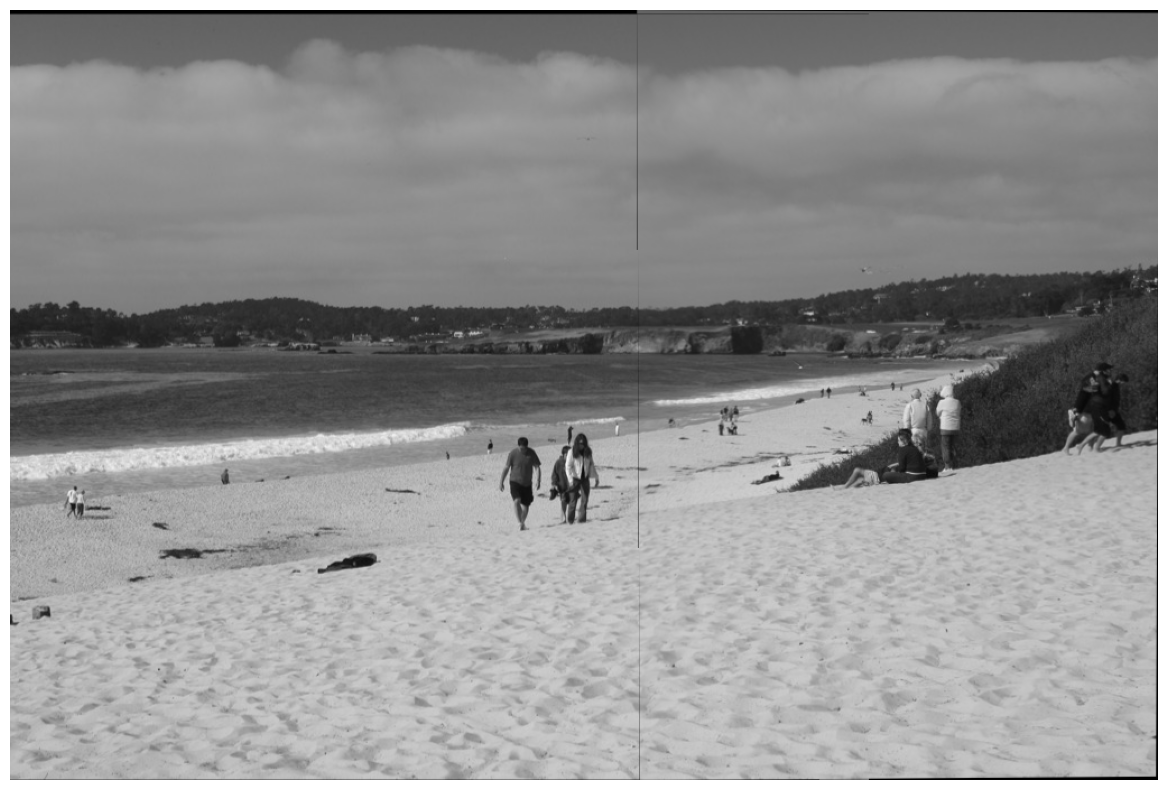

(683, 1024, 3) (683, 1024, 3)
SSIM Score: 0.9999


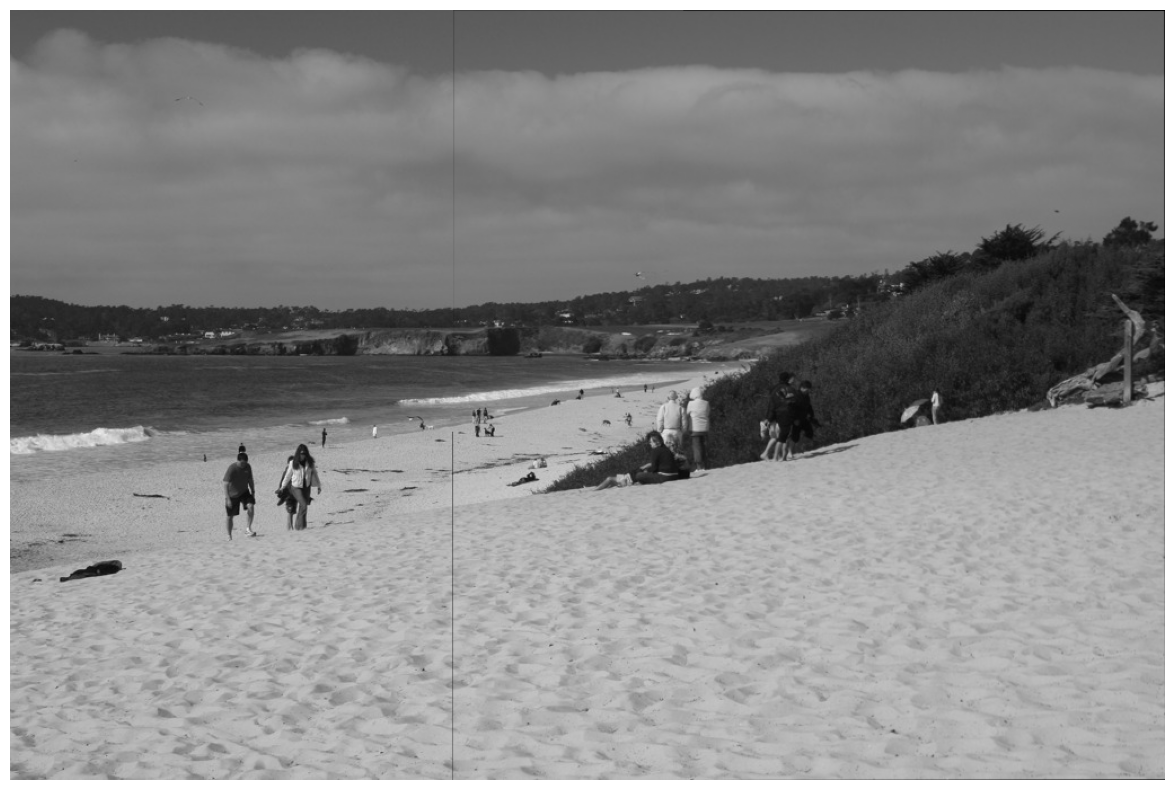

(683, 1024, 3) (683, 1024, 3)
SSIM Score: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..315.94446].


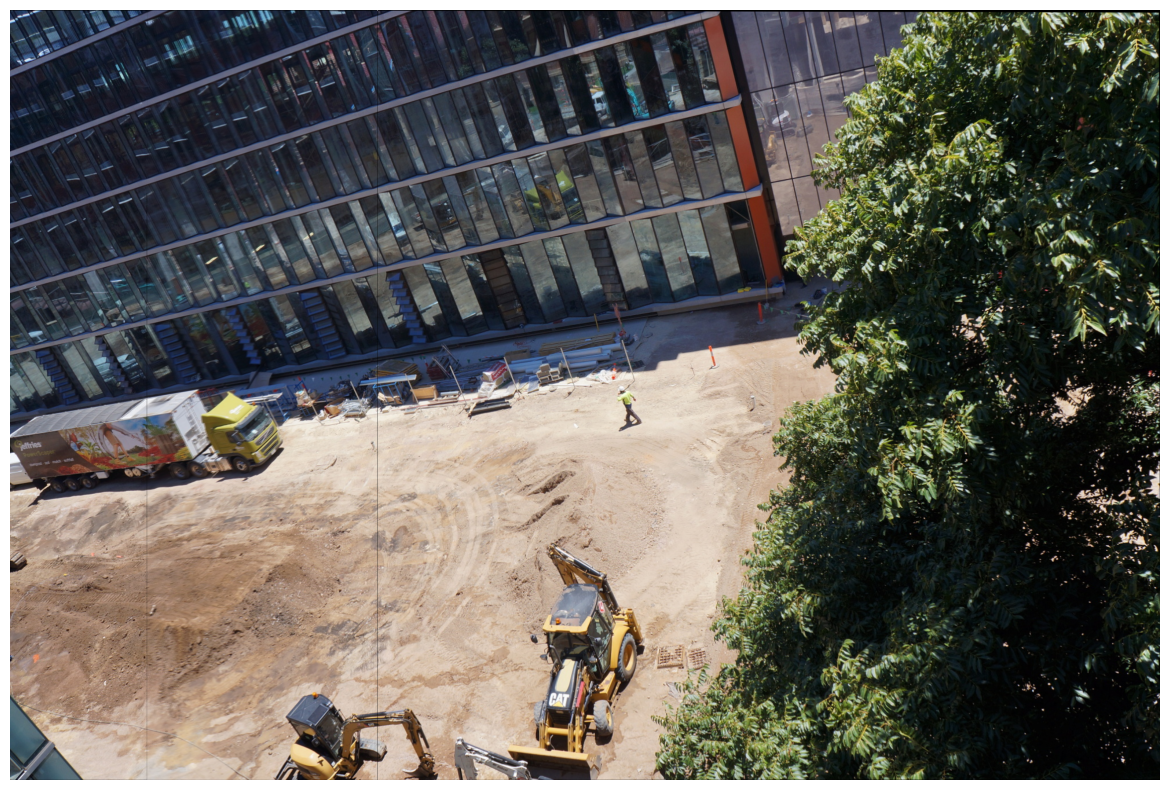

(1329, 2000, 3) (1329, 2000, 3)
SSIM Score: 0.9730


In [58]:
source_path = './test_images/'
image_files = [f for f in glob.glob(source_path + '/*.jpg')]

for image_path in image_files:
    left, right, original = split_image_pil(image_path)

    images_to_stich = [left, right]
    feature_mapping = feature_detection_mapping(images_to_stich)
    
    stitched_image = stitch_images(left, right, feature_mapping[0])

    plt.figure(figsize=(15, 10))
    plt.imshow(stitched_image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

    score, diff = calculate_ssim(original_img=original, stitched_img=stitched_image)
    print(f"SSIM Score: {score:.4f}") 
